In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Add parent directory to path.
from pathlib import Path
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
fdir = Path(os.path.abspath('')).resolve() # Directory of current file.
path = fdir/'..'
if path not in sys.path:
    sys.path.append(str(path))

# Complete imports.
import makassar_ml as ml
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import seaborn as sns
sns.set() # Use seaborn themes.

# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [2]:
keras.backend.clear_session()

In [3]:
# Configure root paths.
config = dict(
    roots=dict(
        hp_tuning_root=Path('~/research/makassar/hp_tuning').expanduser(),
        image_root=Path('~/research/makassar/images').expanduser(),
    ),
)

In [60]:
epochs = 30
batch_size = 256

In [61]:
in_feat = ['TEMP','DEWP','PRES','Iws']
out_feat = ['pm2.5','Ir']
in_seq_len = 24 # 1 day
out_seq_len = 1 # 1 hour

ds_train, ds_val, ds_test = ml.datasets.beijingpm25.load_data(
    path=Path('~/research/makassar/datasets/beijing_pm25').expanduser(),
    in_feat=in_feat,
    out_feat=out_feat,
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=1,
    split=[0.7,0.2,0.1],
    shuffle=False,
    batch_size=batch_size,
)

ds_train = ds_train.prefetch(tf.data.AUTOTUNE).cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE).cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE).cache()

In [62]:
model = ml.models.lstm_net.build_model(
    in_seq_len=in_seq_len,
    in_feat=len(in_feat),
    out_feat=len(out_feat),
    # lstm_units=[1024, 512, 256, 128, 64, 32],
    lstm_units=[1024, 512, 256],
    # lstm_units=[128, 64, 32],
    fc_units=[128, 64],
    dropout=0.1,
)


optimizer = keras.optimizers.Adam(learning_rate=1e-2)
metrics = ['mae']
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=metrics,
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 4)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 24, 1024)          4214784   
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 512)           3147776   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256  

In [63]:
model, history, metrics = ml.training.train_evaluate_model(
    model,
    datagen_train=ds_train,
    datagen_val=ds_val,
    datagen_test=ds_test,
    epochs=epochs,
    checkpoint_path=config['roots']['hp_tuning_root']/'lstm'/'lstm.h5',
    history_path=config['roots']['hp_tuning_root']/'lstm'/'lstm_history.csv',
    metrics_path=config['roots']['hp_tuning_root']/'lstm'/'lstm_metrics.json',
)

Epoch 1/30
115/115 [==============================] - 7s 43ms/step - loss: 34.7843 - mae: 1.8881 - val_loss: 0.8652 - val_mae: 0.5001
Epoch 2/30
115/115 [==============================] - 4s 37ms/step - loss: 1.8727 - mae: 0.7661 - val_loss: 0.8751 - val_mae: 0.5488
Epoch 3/30
115/115 [==============================] - 4s 37ms/step - loss: 1.6976 - mae: 0.6455 - val_loss: 0.8915 - val_mae: 0.5509
Epoch 4/30
115/115 [==============================] - 4s 37ms/step - loss: 1.6872 - mae: 0.6277 - val_loss: 0.8790 - val_mae: 0.5611
Epoch 5/30
115/115 [==============================] - 4s 37ms/step - loss: 1.6422 - mae: 0.6045 - val_loss: 0.8852 - val_mae: 0.5125
Epoch 6/30
115/115 [==============================] - 4s 37ms/step - loss: 1.6574 - mae: 0.5737 - val_loss: 0.8691 - val_mae: 0.4698
Epoch 7/30
115/115 [==============================] - 4s 37ms/step - loss: 1.6410 - mae: 0.5523 - val_loss: 0.8724 - val_mae: 0.4829
Epoch 8/30
115/115 [==============================] - 4s 37ms/step -

/home/acd1797/research/makassar/images/lstm.png


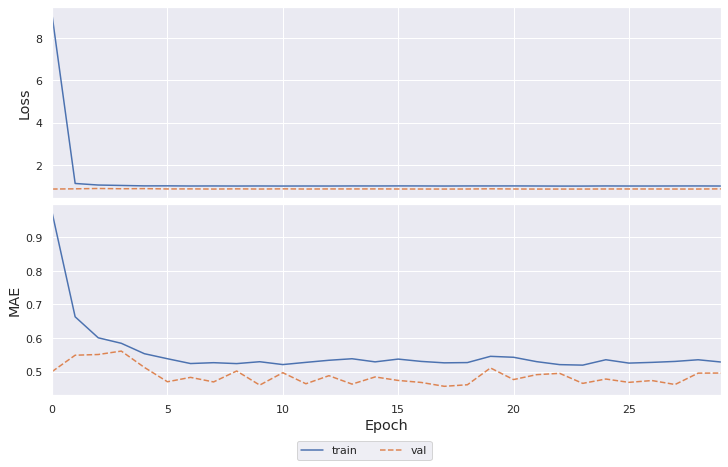

In [4]:
# Load history from file.
history = ml.training.load_history(config['roots']['hp_tuning_root']/'lstm'/'lstm_history.csv')

# Plot train/val performance for best model.
allmetrics = ['loss', 'mae']
fig, ax = plt.subplots(nrows=len(allmetrics), ncols=1, figsize=(10,len(allmetrics)*3), sharex=True, constrained_layout=True)
for j, key in enumerate(sorted(allmetrics)):
    ax[j].plot(history[key], label=f'train', linestyle='-')
    ax[j].plot(history[f"val_{key}"], label=f'val', linestyle='--')
    ax[j].set_xlim(0, len(history[key])-1)
    if j == len(allmetrics)-1:
        ax[j].set_xlabel('Epoch', fontsize='large')

    if key == 'loss':
        ax[j].set_ylabel(key.capitalize(), fontsize='large')
    else:
        ax[j].set_ylabel(key.upper(), fontsize='large')
    # ax[j].legend(loc='upper left')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5,0.0))
path = Path(config['roots']['image_root'])/f"lstm.png"
fig.savefig(path, bbox_inches='tight')
print(path)